In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats as stat
import seaborn as sb
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import XGBClassifier

In [128]:
# Importing the dataset
dataset = pd.read_csv('sgemm_product.csv')

In [129]:
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


In [130]:
dataset.shape

(241600, 18)

In [131]:
dataset.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


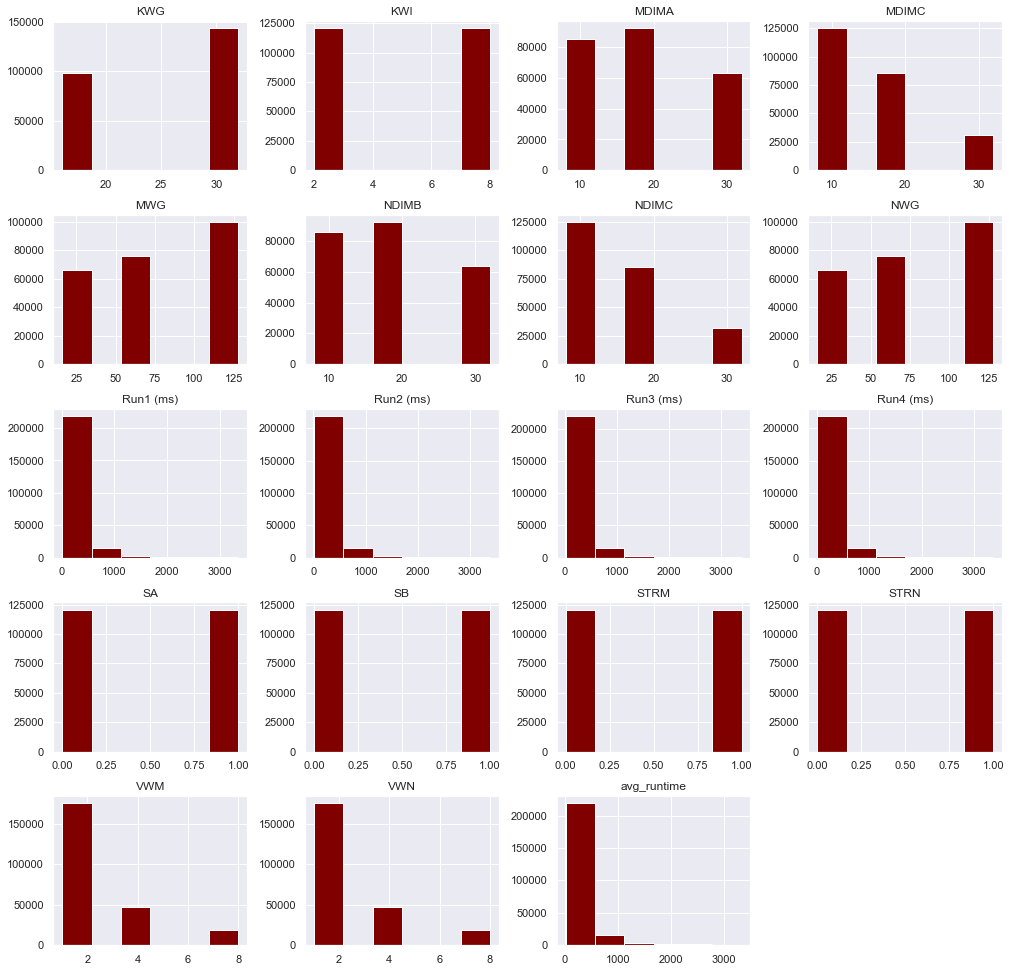

In [132]:
dataset['avg_runtime'] = dataset.iloc[:,14:18].mean(axis=1)
#taking mean of 4 variables
sgemm = pd.DataFrame(dataset)
sgemm
sgemm['avg_runtime'] = sgemm.iloc[:,14:18].mean(axis=1)
sgemm.hist(bins = 6 , figsize=(17,17), color = 'maroon');

Text(0.5, 0, 'Average Runtime')

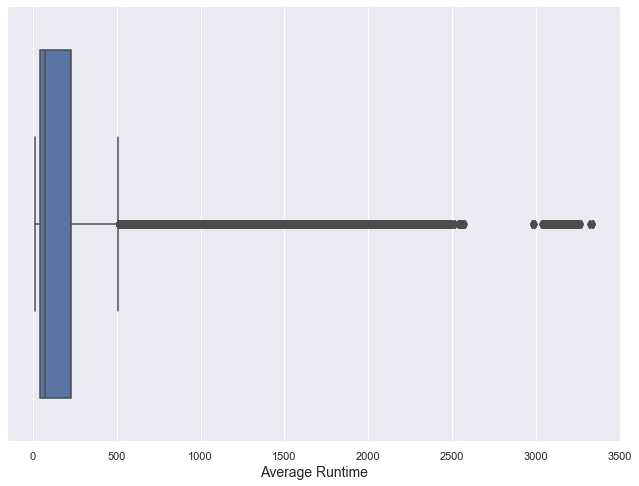

In [133]:
#boxplot
plt.figure(figsize=(11,8))
sb.boxplot(x="avg_runtime", data=sgemm)
plt.xlabel('Average Runtime', fontsize=14)

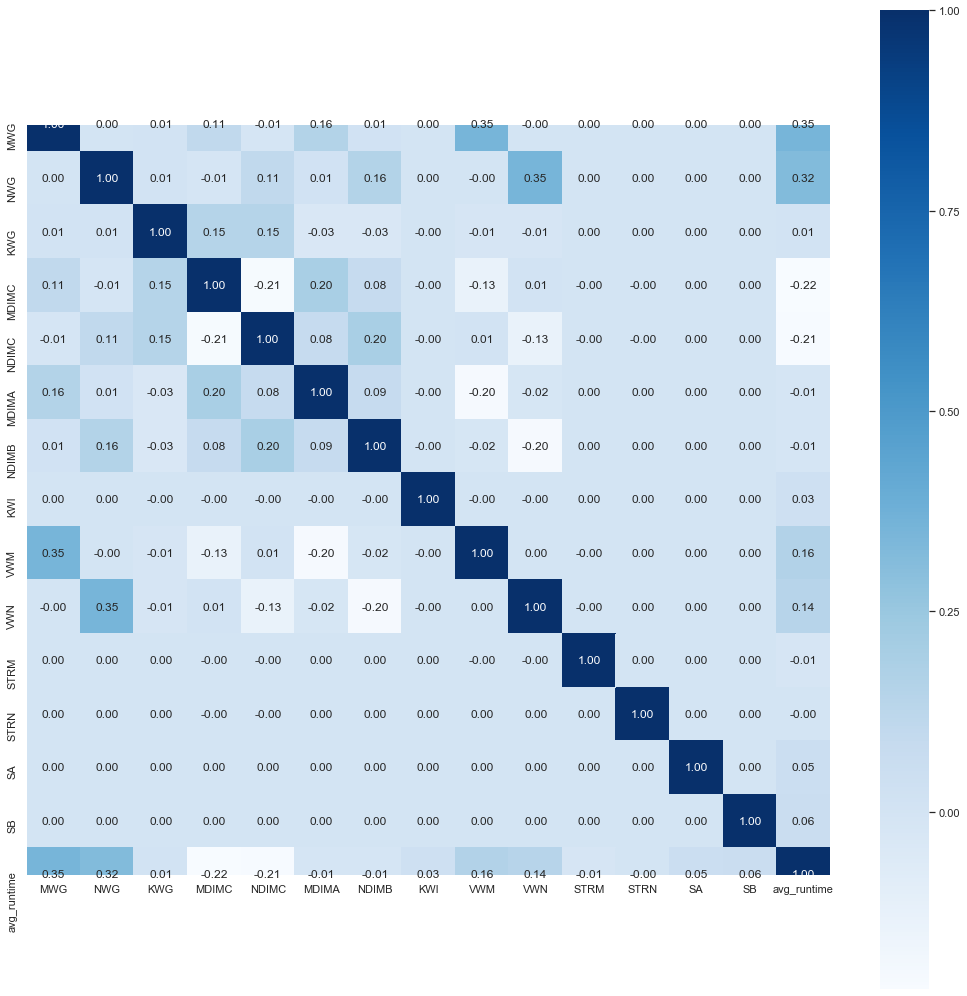

In [134]:
#Plotting correlation matrix
sgemmvar = ['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'avg_runtime']
sgemmcorr= sgemm[sgemmvar]
corr=sgemmcorr.corr()
plt.figure(figsize = (18,18))
sb.set(font_scale=1)
sb.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=sgemmvar, yticklabels=sgemmvar, cmap="Blues",)
plt.show();

In [135]:
#Taking 2sigmas
sgemm1 = sgemm.drop(sgemm[(sgemm.avg_runtime>sgemm.avg_runtime.quantile(0.975))].index)
sgemm2 = sgemm1.drop(sgemm1[(sgemm1.avg_runtime<sgemm.avg_runtime.quantile(0.025))].index) 
sgemm2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229520 entries, 0 to 241598
Data columns (total 19 columns):
MWG            229520 non-null int64
NWG            229520 non-null int64
KWG            229520 non-null int64
MDIMC          229520 non-null int64
NDIMC          229520 non-null int64
MDIMA          229520 non-null int64
NDIMB          229520 non-null int64
KWI            229520 non-null int64
VWM            229520 non-null int64
VWN            229520 non-null int64
STRM           229520 non-null int64
STRN           229520 non-null int64
SA             229520 non-null int64
SB             229520 non-null int64
Run1 (ms)      229520 non-null float64
Run2 (ms)      229520 non-null float64
Run3 (ms)      229520 non-null float64
Run4 (ms)      229520 non-null float64
avg_runtime    229520 non-null float64
dtypes: float64(5), int64(14)
memory usage: 35.0 MB


In [136]:
sgemm2.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),avg_runtime
count,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000,229520.000000
mean,79.503799,79.212130,25.532659,14.048100,13.960404,17.282921,17.278913,4.984864,2.429078,2.417005,0.495674,0.498671,0.481322,0.486171,176.062995,176.046375,176.002530,175.993503,176.026351
std,42.590214,42.551021,7.851829,7.884239,7.836359,9.366788,9.365922,2.999968,1.951373,1.942145,0.499982,0.499999,0.499652,0.499810,223.598338,223.383485,223.381709,223.381412,223.430831
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,22.310000,22.110000,22.620000,22.340000,23.430000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,41.400000,41.470000,41.410000,41.380000,41.410000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,69.825000,69.930000,69.790000,69.820000,69.790000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,217.010000,216.250000,216.270000,216.330000,216.623125
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1176.460000,1174.300000,1173.700000,1173.470000,1170.632500


# Support Vector Machines

INITIAL SETUP : With default parameter values <br>
Kernel - Linear, Gaussian & Polynomial

In [137]:
#Turning this dataset into a Classification problem
x = sgemm2.iloc[:,:-5]
temp = sgemm2['avg_runtime'].quantile(0.5)
y = sgemm2['avg_runtime'].apply(lambda x: 1 if x > temp else 0)

In [138]:
y.describe()

count    229520.000000
mean          0.499996
std           0.500001
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: avg_runtime, dtype: float64

In [139]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [140]:
scaler = StandardScaler()
x1_train=scaler.fit_transform(x1_train)
x1_test=scaler.transform(x1_test)

In [179]:
model = SVC(kernel='linear')

In [16]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 20min 41s, sys: 4.08 s, total: 20min 45s
Wall time: 20min 47s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.8234866968746369
Confusion Matrix: 
 [[29293  5083]
 [ 7071 27409]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83     34376
           1       0.84      0.79      0.82     34480

    accuracy                           0.82     68856
   macro avg       0.82      0.82      0.82     68856
weighted avg       0.82      0.82      0.82     68856



In [18]:
model = SVC(kernel='rbf')

In [19]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 6min 44s, sys: 1.14 s, total: 6min 45s
Wall time: 6min 46s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [20]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.9575345648890438
Confusion Matrix: 
 [[33501   875]
 [ 2049 32431]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96     34376
           1       0.97      0.94      0.96     34480

    accuracy                           0.96     68856
   macro avg       0.96      0.96      0.96     68856
weighted avg       0.96      0.96      0.96     68856



In [21]:
model = SVC(kernel='poly')

In [22]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 8min 39s, sys: 2.31 s, total: 8min 41s
Wall time: 3h 4min 42s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.9045108632508423
Confusion Matrix: 
 [[32398  1978]
 [ 4597 29883]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     34376
           1       0.94      0.87      0.90     34480

    accuracy                           0.90     68856
   macro avg       0.91      0.90      0.90     68856
weighted avg       0.91      0.90      0.90     68856



#Tuning the Hyperparameters of SVM

In [38]:
sgemm3 = sgemm2.sample(int(0.1*len(sgemm2)))
x = sgemm3.iloc[:,:-5]
temp = sgemm3['avg_runtime'].quantile(0.5)
y = sgemm3['avg_runtime'].apply(lambda x: 1 if x > temp else 0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [39]:
len(y_train)

16066

Linear Kernel

In [26]:
param_grid = {'C': [1,10,100], 'gamma': [0.1,0.01,0.001], 'kernel': ['linear']} 

In [27]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [28]:
grid.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.836, total=   6.2s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.834, total=   6.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.832, total=   6.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.842, total=   6.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.841, total=   6.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.836, total=   5.9s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.834, total=   6.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.832, total=   6.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.842, total=   6.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 72.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [29]:
grid.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [30]:
grid.best_estimator_

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
grid_predictions = grid.predict(x_test)
print('Confusion Matrix: \n', confusion_matrix(y_test,grid_predictions))
print('Classification Report: \n', classification_report(y_test,grid_predictions))

Confusion Matrix: 
 [[2940  456]
 [ 709 2781]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.83      3396
           1       0.86      0.80      0.83      3490

    accuracy                           0.83      6886
   macro avg       0.83      0.83      0.83      6886
weighted avg       0.83      0.83      0.83      6886



In [32]:
model = SVC(C=1,gamma=0.1,kernel='linear')

In [33]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 20min 22s, sys: 3.26 s, total: 20min 25s
Wall time: 24min 59s


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.8234866968746369
Confusion Matrix: 
 [[29293  5083]
 [ 7071 27409]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83     34376
           1       0.84      0.79      0.82     34480

    accuracy                           0.82     68856
   macro avg       0.82      0.82      0.82     68856
weighted avg       0.82      0.82      0.82     68856



In [40]:
model = SVC(C=1,gamma=0.1,kernel='linear')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.81507297 0.81964714 0.81960784 0.8211329  0.808061  ]
Accuracy: 0.82 (+/- 0.01)


Gaussian Kernel

In [141]:
param_grid = {'C': [1,10,100], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf']} 

In [142]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [37]:
grid.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.936, total=   3.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.935, total=   3.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.942, total=   3.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.935, total=   3.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.934, total=   3.3s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.869, total=   3.7s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.872, total=   3.7s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.878, total=   3.8s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.875, total=   4.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [38]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [39]:
grid.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
grid_predictions = grid.predict(x_test)
print('Confusion Matrix: \n', confusion_matrix(y_test,grid_predictions))
print('Classification Report: \n', classification_report(y_test,grid_predictions))

Confusion Matrix: 
 [[3276  120]
 [ 248 3242]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      3396
           1       0.96      0.93      0.95      3490

    accuracy                           0.95      6886
   macro avg       0.95      0.95      0.95      6886
weighted avg       0.95      0.95      0.95      6886



In [143]:
model = SVC(C=10,gamma=0.1,kernel='rbf')

In [144]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 8min 32s, sys: 2.83 s, total: 8min 35s
Wall time: 8min 36s


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [145]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.979261066573719
Confusion Matrix: 
 [[33798   578]
 [  850 33630]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     34376
           1       0.98      0.98      0.98     34480

    accuracy                           0.98     68856
   macro avg       0.98      0.98      0.98     68856
weighted avg       0.98      0.98      0.98     68856



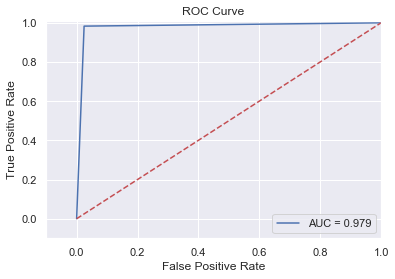

In [146]:
def roc_auc(y_test,y_pred):
    sb.set()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend()
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
roc_auc(predictions,y1_test)

In [41]:
model = SVC(C=10,gamma=0.1,kernel='rbf')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.89087345 0.88194293 0.8745098  0.8869281  0.87211329]
Accuracy: 0.88 (+/- 0.01)


Polynomial Kernel

In [14]:
param_grid = {'C': [1,10,100], 'degree' : [3,5], 'gamma': [0.1,0.01,0.001], 'kernel': ['poly']} 

In [15]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [16]:
grid.fit(x_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.889, total=   4.5s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.886, total=   4.1s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.880, total=   4.2s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.882, total=   4.3s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.887, total=   4.2s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.696, total=   4.9s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.693, total=   4.9s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.703, total=   4.9s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.698, total=   4.8s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ......................

[CV]  C=10, degree=5, gamma=0.001, kernel=poly, score=0.501, total=   5.2s
[CV] C=100, degree=3, gamma=0.1, kernel=poly .........................
[CV]  C=100, degree=3, gamma=0.1, kernel=poly, score=0.907, total= 1.2min
[CV] C=100, degree=3, gamma=0.1, kernel=poly .........................
[CV]  C=100, degree=3, gamma=0.1, kernel=poly, score=0.915, total= 1.3min
[CV] C=100, degree=3, gamma=0.1, kernel=poly .........................
[CV]  C=100, degree=3, gamma=0.1, kernel=poly, score=0.905, total= 1.3min
[CV] C=100, degree=3, gamma=0.1, kernel=poly .........................
[CV]  C=100, degree=3, gamma=0.1, kernel=poly, score=0.910, total= 1.1min
[CV] C=100, degree=3, gamma=0.1, kernel=poly .........................
[CV]  C=100, degree=3, gamma=0.1, kernel=poly, score=0.904, total= 1.0min
[CV] C=100, degree=3, gamma=0.01, kernel=poly ........................
[CV]  C=100, degree=3, gamma=0.01, kernel=poly, score=0.841, total=   3.4s
[CV] C=100, degree=3, gamma=0.01, kernel=poly ........

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 14.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'degree': [3, 5],
                         'gamma': [0.1, 0.01, 0.001], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [19]:
param_grid = {'C': [10], 'degree' : [3,5], 'gamma': [0.1], 'kernel': ['poly']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] C=10, degree=3, gamma=0.1, kernel=poly ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=10, degree=3, gamma=0.1, kernel=poly, score=0.905, total=  10.0s
[CV] C=10, degree=3, gamma=0.1, kernel=poly ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  C=10, degree=3, gamma=0.1, kernel=poly, score=0.900, total=   9.8s
[CV] C=10, degree=3, gamma=0.1, kernel=poly ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.8s remaining:    0.0s


[CV]  C=10, degree=3, gamma=0.1, kernel=poly, score=0.896, total=   9.5s
[CV] C=10, degree=3, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=3, gamma=0.1, kernel=poly, score=0.895, total=   9.5s
[CV] C=10, degree=3, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=3, gamma=0.1, kernel=poly, score=0.898, total=   9.7s
[CV] C=10, degree=5, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=5, gamma=0.1, kernel=poly, score=0.899, total=  11.9s
[CV] C=10, degree=5, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=5, gamma=0.1, kernel=poly, score=0.891, total=  12.5s
[CV] C=10, degree=5, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=5, gamma=0.1, kernel=poly, score=0.895, total=  11.2s
[CV] C=10, degree=5, gamma=0.1, kernel=poly ..........................
[CV]  C=10, degree=5, gamma=0.1, kernel=poly, score=0.889, total=  11.3s
[CV] C=10, degree=5, gamma=0.1, kernel=poly ...................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10], 'degree': [3, 5], 'gamma': [0.1],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [20]:
grid.best_params_

{'C': 10, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}

In [20]:
grid.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
grid_predictions = grid.predict(x_test)
print('Accuracy:',accuracy_score(y_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y_test,grid_predictions))
print('Classification Report: \n', classification_report(y_test,grid_predictions))

Accuracy: 0.9054603543421434
Confusion Matrix: 
 [[3264  199]
 [ 452 2971]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      3463
           1       0.94      0.87      0.90      3423

    accuracy                           0.91      6886
   macro avg       0.91      0.91      0.91      6886
weighted avg       0.91      0.91      0.91      6886



In [22]:
model = SVC(C=10,degree=3,gamma=0.1,kernel='poly')

In [23]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 28min 29s, sys: 9.09 s, total: 28min 38s
Wall time: 28min 46s


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.9182642035552457
Confusion Matrix: 
 [[32416  1960]
 [ 3668 30812]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     34376
           1       0.94      0.89      0.92     34480

    accuracy                           0.92     68856
   macro avg       0.92      0.92      0.92     68856
weighted avg       0.92      0.92      0.92     68856



In [ ]:
model = SVC(C=10,degree=3,gamma=0.1,kernel='poly')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Decision Trees

In [373]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtc = dtc.fit(x1_train,y1_train)

In [374]:
trainacc = dtc.score(x1_train,y1_train)
print('Accuracy - Training set: {:.2f}'.format(trainacc))

Accuracy - Training set: 1.00


In [375]:
#Predict the response for test dataset
predictions = dtc.predict(x1_test)
# print classification report 
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test, predictions))
print('Classification Report: \n',classification_report(y1_test, predictions)) 

Accuracy: 0.9897031485999768
Confusion Matrix: 
 [[34013   363]
 [  346 34134]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     34376
           1       0.99      0.99      0.99     34480

    accuracy                           0.99     68856
   macro avg       0.99      0.99      0.99     68856
weighted avg       0.99      0.99      0.99     68856



#Decision Trees - Hyperparameter tuning

In [376]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [2, 5, 10, 20],
              "max_leaf_nodes": [None, 5, 10, 20]
              }
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 2) 

In [377]:
grid.fit(x1_train, y1_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.1s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .

[CV] criterion=gini, max_depth=20, max_leaf_nodes=None ...............
[CV]  criterion=gini, max_depth=20, max_leaf_nodes=None, total=   0.3s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=None ...............
[CV]  criterion=gini, max_depth=20, max_leaf_nodes=None, total=   0.3s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=None ...............
[CV]  criterion=gini, max_depth=20, max_leaf_nodes=None, total=   0.3s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=None ...............
[CV]  criterion=gini, max_depth=20, max_leaf_nodes=None, total=   0.3s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=None ...............
[CV]  criterion=gini, max_depth=20, max_leaf_nodes=None, total=   0.3s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=5 ..................
[CV] ... criterion=gini, max_depth=20, max_leaf_nodes=5, total=   0.1s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=5 ..................
[CV] ... criterion=gini, max_depth=20, max_leaf_nodes=5, total=   0.2s
[CV] c

[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=None, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=None, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=None, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=None, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=None, total=   0.3s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=5 ...............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=5, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=5 ...............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=5, total=   0.2s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=5 .......

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   28.0s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [378]:
print('Best Parameter: ', grid.best_params_) 

print('Model: ', grid.best_estimator_)

Best Parameter:  {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': None}
Model:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [379]:
# dt1=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
#             max_features=None, max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#             splitter='best')
# dt1 = dt1.fit(x1_train,y1_train)

In [380]:
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

Accuracy: 0.9904002556059022
Confusion Matrix: 
 [[34049   327]
 [  334 34146]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     34376
           1       0.99      0.99      0.99     34480

    accuracy                           0.99     68856
   macro avg       0.99      0.99      0.99     68856
weighted avg       0.99      0.99      0.99     68856



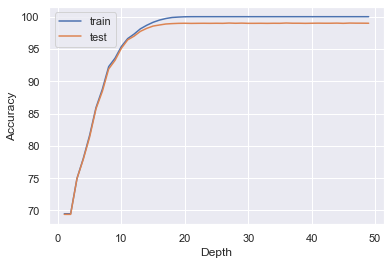

In [381]:
test_accuracy = []
train_accuracy = []
depth = []
for i in range(1,grid.best_params_['max_depth']+30):
    dtc = DecisionTreeClassifier(max_depth=i)
# Train Decision Tree Classifer
    dtc = dtc.fit(x1_train,y1_train)

    predictionstest = dtc.predict(x1_test)
    predictionstrain = dtc.predict(x1_train)

    test_accuracy.append(accuracy_score(y1_test,predictionstest)*100)
    train_accuracy.append(accuracy_score(y1_train,predictionstrain)*100)
    depth.append(i)
    
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.plot(depth,train_accuracy, label='train')
plt.plot(depth,test_accuracy, label='test')
plt.legend()
plt.show()

In [382]:
model = DecisionTreeClassifier(max_depth=20)
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.98761398 0.98926337 0.98864096 0.98758286 0.98786257]
Accuracy: 0.99 (+/- 0.00)


In [91]:
x

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241593,128,128,32,32,32,32,32,8,4,4,1,0,0,1
241594,128,128,32,32,32,32,32,8,4,4,1,0,1,0
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1


# BOOSTING

In [88]:
%%time
adb = AdaBoostClassifier(n_estimators=100,learning_rate=1)
adb = adb.fit(x1_train, y1_train)

CPU times: user 6.45 s, sys: 453 ms, total: 6.9 s
Wall time: 6.91 s


In [90]:
#Predict the response for test dataset
predictions = adb.predict(x1_test)
# print classification report 
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test, predictions))
print('Classification Report: \n',classification_report(y1_test, predictions)) 

Accuracy: 0.7932351574299988
Confusion Matrix: 
 [[26527  7849]
 [ 6388 28092]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79     34376
           1       0.78      0.81      0.80     34480

    accuracy                           0.79     68856
   macro avg       0.79      0.79      0.79     68856
weighted avg       0.79      0.79      0.79     68856



In [386]:
# param_grid = {"n_estimators": [50, 100, 500, 1000, 1500],
#               "learning_rate": [0.1, 1, 2]
#               }
# grid = GridSearchCV(AdaBoostClassifier(), param_grid, refit = True, verbose = 2) 

# grid.fit(x1_train, y1_train)

# print('Best Parameter: ', grid.best_params_) 

# print('Model: ', grid.best_estimator_)

In [387]:
# grid_predictions = grid.predict(x1_test)
# print('Accuracy:',accuracy_score(y1_test,grid_predictions))
# print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
# print('Classification Report: \n', classification_report(y1_test,grid_predictions))

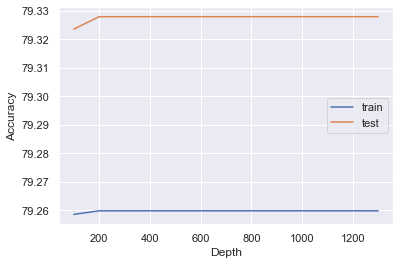

In [388]:
test_accuracy = []
train_accuracy = []
depth = []
for i in range(100,1001+300,100):
    dtc = AdaBoostClassifier(n_estimators=i, learning_rate=1)
# Train Decision Tree Classifer
    dtc = dtc.fit(x1_train,y1_train)

    predictionstest = dtc.predict(x1_test)
    predictionstrain = dtc.predict(x1_train)

    test_accuracy.append(accuracy_score(y1_test,predictionstest)*100)
    train_accuracy.append(accuracy_score(y1_train,predictionstrain)*100)
    depth.append(i)
    
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.plot(depth,train_accuracy, label='train')
plt.plot(depth,test_accuracy, label='test')
plt.legend()
plt.show()

In [67]:
model = AdaBoostClassifier(n_estimators=300, learning_rate=1)
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.86678201 0.85194805 0.84069264 0.85714286 0.85714286]
Accuracy: 0.85 (+/- 0.02)


# INCOME DATA

In [101]:
incomedata = pd.read_csv('income_evaluation.csv')

In [102]:
incomedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [103]:
#missing data
total = incomedata.isnull().sum().sort_values(ascending=False)
percent = (incomedata.isnull().sum()/incomedata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
income,0,0.0
native_country,0,0.0
hours-per-week,0,0.0
capital-loss,0,0.0
capital-gain,0,0.0
sex,0,0.0
race,0,0.0
relationship,0,0.0
occupation,0,0.0
marital-status,0,0.0


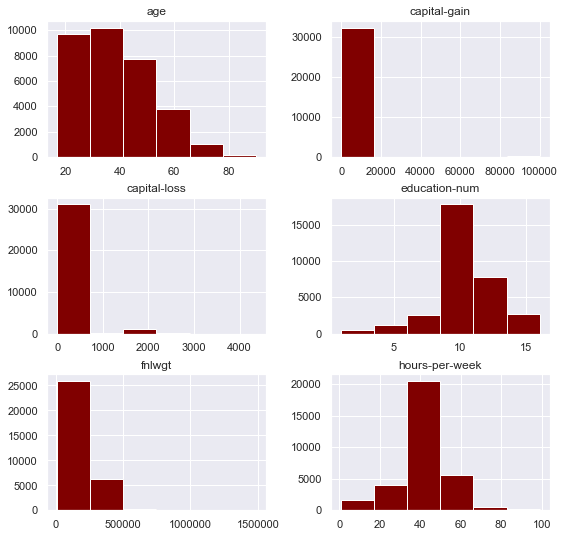

In [104]:
incomedata.hist(bins = 6 , figsize=(9,9), color = 'maroon');

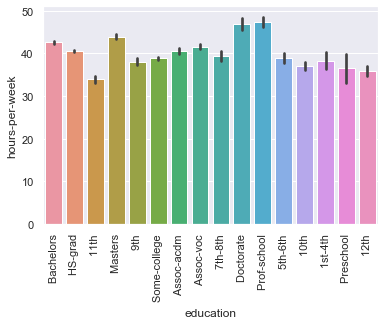

In [105]:
bplot = sb.barplot(x = incomedata['education'], y = incomedata['hours-per-week'], data = incomedata)
plt.setp(bplot.get_xticklabels(), rotation=90);

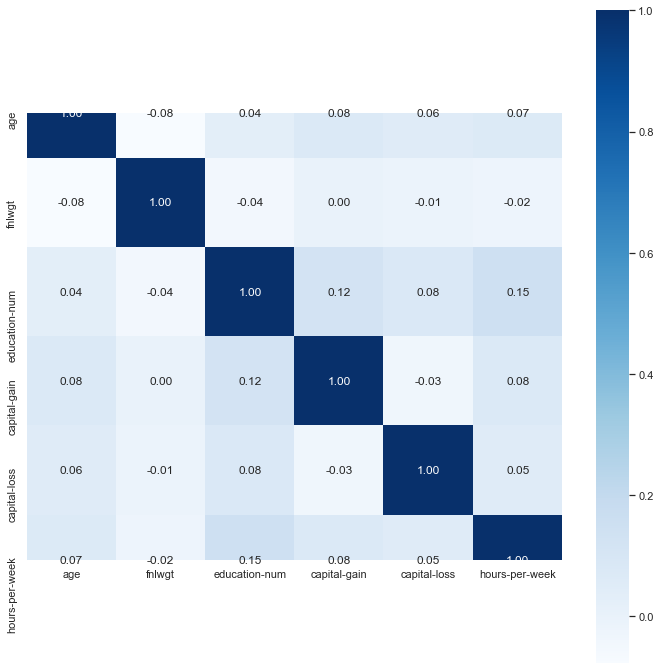

In [106]:
#Plotting correlation matrix
incomevar = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
incomecorr= incomedata[incomevar]
corr=incomecorr.corr()
plt.figure(figsize = (12,12))
sb.set(font_scale=1)
sb.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=incomevar, yticklabels=incomevar, cmap="Blues",)
plt.show();

incomedata

In [107]:
incomedata = incomedata[incomedata.native_country.str.strip() == 'United-States']
incomedata = incomedata[incomedata.occupation.str.strip() != '?']
incomenew = incomedata.iloc[:, incomedata.columns != 'native_country'].sample(int(0.7*len(incomedata)))
incomenew
#incomedata.native_country.str.strip() != '?' &
                           #incomedata.workclass.str.strip() != '?'

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
15927,54,Private,213092,HS-grad,9,Divorced,Other-service,Not-in-family,White,Female,0,0,40,<=50K
17549,46,Private,174995,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,45,<=50K
28527,27,Private,132805,10th,6,Never-married,Sales,Other-relative,White,Male,0,1980,40,<=50K
30253,43,Private,214781,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,<=50K
9102,68,Private,201732,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12450,41,Self-emp-not-inc,57924,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,7688,0,50,>50K
6796,47,State-gov,103743,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,<=50K
28413,26,Private,205036,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,42,<=50K
24759,59,Self-emp-not-inc,170411,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,<=50K


In [108]:
#See unique values and convert them to int using pd.getDummies()
catcol = ['workclass','education','marital-status','occupation','relationship','race',
                       'sex']
for col in catcol:  
    print(np.unique(incomenew[col]))
# transform the categorical columns
income = pd.get_dummies(incomenew, columns=catcol)
income

[' Federal-gov' ' Local-gov' ' Private' ' Self-emp-inc'
 ' Self-emp-not-inc' ' State-gov' ' Without-pay']
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
[' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
[' Female' ' Male']


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
15927,54,213092,9,0,0,40,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,1,0
17549,46,174995,9,0,0,45,<=50K,0,0,1,...,0,1,0,0,0,0,0,1,1,0
28527,27,132805,6,0,1980,40,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,1
30253,43,214781,14,0,0,45,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,1
9102,68,201732,10,0,0,40,<=50K,0,0,1,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12450,41,57924,10,7688,0,50,>50K,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6796,47,103743,4,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,1
28413,26,205036,9,0,0,42,<=50K,0,0,1,...,0,0,0,0,0,0,0,1,0,1
24759,59,170411,4,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [109]:
x = income.iloc[:, income.columns != 'income']
# temp = sgemm2['avg_runtime'].quantile(0.5)
y = income['income'].apply(lambda x: 0 if x.strip() == '<=50K' else 1)

In [110]:
y.sum()

4903

In [111]:
x

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
15927,54,213092,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
17549,46,174995,9,0,0,45,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
28527,27,132805,6,0,1980,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
30253,43,214781,14,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
9102,68,201732,10,0,0,40,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12450,41,57924,10,7688,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6796,47,103743,4,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
28413,26,205036,9,0,0,42,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
24759,59,170411,4,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [112]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [113]:
scaler = StandardScaler()
x1_train=scaler.fit_transform(x1_train)
x1_test=scaler.transform(x1_test)

In [114]:
y1_test.sum()

1518

In [115]:
y1_test

1162     1
32294    0
527      0
26612    0
12484    0
        ..
21620    0
31542    1
10593    0
261      0
18273    0
Name: income, Length: 5776, dtype: int64

Linear Kernel

In [116]:
model = SVC(kernel='linear')

In [30]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 12.3 s, sys: 154 ms, total: 12.4 s
Wall time: 12.4 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.847472299168975
Confusion Matrix: 
 [[4030  307]
 [ 574  865]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4337
           1       0.74      0.60      0.66      1439

    accuracy                           0.85      5776
   macro avg       0.81      0.77      0.78      5776
weighted avg       0.84      0.85      0.84      5776



In [32]:
param_grid = {'C': [1,10,100], 'gamma': [0.1,0.01,0.001], 'kernel': ['linear']} 

In [33]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x1_train,y1_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.849, total=   9.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.836, total=   8.5s
[CV] C=1, gamma=0.1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.843, total=   8.1s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.835, total=   8.5s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.848, total=   8.8s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.849, total=   9.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.836, total=   8.4s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.843, total=   8.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.835, total=   8.4s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 62.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [34]:
print(grid.best_params_)
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Accuracy: 0.847472299168975
Confusion Matrix: 
 [[4030  307]
 [ 574  865]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4337
           1       0.74      0.60      0.66      1439

    accuracy                           0.85      5776
   macro avg       0.81      0.77      0.78      5776
weighted avg       0.84      0.85      0.84      5776



In [35]:
model = SVC(C = 10, gamma = 0.1, kernel = 'linear')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.84866469 0.83636364 0.84267161 0.83487941 0.84786642]
Accuracy: 0.84 (+/- 0.01)


Gaussian Kernel

In [36]:
model = SVC(kernel='rbf')

In [37]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 8 s, sys: 159 ms, total: 8.16 s
Wall time: 8.17 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.8459141274238227
Confusion Matrix: 
 [[4020  317]
 [ 573  866]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4337
           1       0.73      0.60      0.66      1439

    accuracy                           0.85      5776
   macro avg       0.80      0.76      0.78      5776
weighted avg       0.84      0.85      0.84      5776



In [39]:
# from sklearn.model_selection import cross_val_score
# #clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
# print('Scores: ',scores)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [40]:
# # Plotting the mean accuracies found from cross validtion and test set accuracy
# plt.plot(np.arange(0,5,1),scores,marker = 'o' , markersize = 6 , color = 'red',label='Folds')
# plt.title(" Accuracies of different Folds ")
# plt.xlabel("Folds")
# plt.grid()
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [117]:
param_grid = {'C': [1,10,100], 'gamma': [0.1,0.01,0.001], 'kernel': ['rbf']} 

In [118]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x1_train,y1_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.826, total=  10.4s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.809, total=  10.2s
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.7s remaining:    0.0s


[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.816, total=   9.7s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.812, total=   9.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.810, total=   9.4s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.855, total=   5.6s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.838, total=   5.6s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.846, total=   5.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.842, total=   5.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [119]:
%%time
print(grid.best_params_)
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.83898891966759
Confusion Matrix: 
 [[3959  299]
 [ 631  887]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4258
           1       0.75      0.58      0.66      1518

    accuracy                           0.84      5776
   macro avg       0.81      0.76      0.78      5776
weighted avg       0.83      0.84      0.83      5776

CPU times: user 1.76 s, sys: 13.6 ms, total: 1.77 s
Wall time: 1.77 s


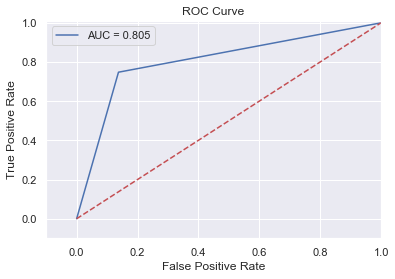

In [126]:
roc_auc(grid_predictions,y1_test)

In [44]:
model = SVC(C = 100, gamma = 0.001, kernel = 'rbf')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.85459941 0.84675325 0.84675325 0.83599258 0.84378479]
Accuracy: 0.85 (+/- 0.01)


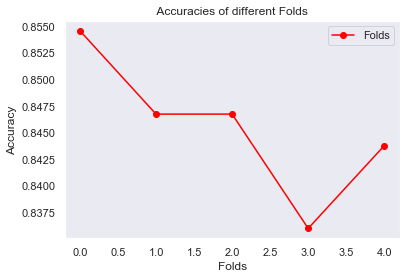

In [45]:
# Plotting the mean accuracies found from cross validtion and test set accuracy
plt.plot(np.arange(0,5,1),scores,marker = 'o' , markersize = 6 , color = 'red',label='Folds')
plt.title(" Accuracies of different Folds ")
plt.xlabel("Folds")
plt.grid()
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Polynomial Kernel

In [46]:
model = SVC(kernel='poly')

In [47]:
%%time
model.fit(x1_train,y1_train)

CPU times: user 7.44 s, sys: 153 ms, total: 7.59 s
Wall time: 7.6 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
predictions = model.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test,predictions))
print('Classification Report: \n',classification_report(y1_test,predictions))

Accuracy: 0.8355263157894737
Confusion Matrix: 
 [[4050  287]
 [ 663  776]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      4337
           1       0.73      0.54      0.62      1439

    accuracy                           0.84      5776
   macro avg       0.79      0.74      0.76      5776
weighted avg       0.83      0.84      0.83      5776



In [49]:
param_grid = {'C': [1,10], 'degree' : [3,5], 'gamma': [0.1,0.01,0.001], 'kernel': ['poly']} 

In [50]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid.fit(x1_train,y1_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.800, total=  14.0s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.799, total=  13.4s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.4s remaining:    0.0s


[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.799, total=  11.6s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.794, total=  11.0s
[CV] C=1, degree=3, gamma=0.1, kernel=poly ...........................
[CV]  C=1, degree=3, gamma=0.1, kernel=poly, score=0.801, total=  13.0s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.820, total=   6.2s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.820, total=   5.9s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.817, total=   5.8s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ..........................
[CV]  C=1, degree=3, gamma=0.01, kernel=poly, score=0.814, total=   6.0s
[CV] C=1, degree=3, gamma=0.01, kernel=poly ......................

[CV]  C=10, degree=5, gamma=0.001, kernel=poly, score=0.743, total=   5.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'degree': [3, 5],
                         'gamma': [0.1, 0.01, 0.001], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [51]:
print(grid.best_params_)
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

{'C': 10, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
Accuracy: 0.8325831024930748
Confusion Matrix: 
 [[3998  339]
 [ 628  811]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4337
           1       0.71      0.56      0.63      1439

    accuracy                           0.83      5776
   macro avg       0.78      0.74      0.76      5776
weighted avg       0.82      0.83      0.83      5776



In [66]:
model = SVC(C = 10, gamma = 0.01,degree =3, kernel = 'poly')
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.82937685 0.8296846  0.82077922 0.81966605 0.81966605]
Accuracy: 0.82 (+/- 0.01)


# DECISION TREES

In [52]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtc = dtc.fit(x1_train,y1_train)

trainacc = dtc.score(x1_train,y1_train)
print('Accuracy - Training set: {:.2f}'.format(trainacc))

Accuracy - Training set: 1.00


In [53]:
#Predict the response for test dataset
predictions = dtc.predict(x1_test)
# print classification report 
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test, predictions))
print('Classification Report: \n',classification_report(y1_test, predictions)) 

Accuracy: 0.8043628808864266
Confusion Matrix: 
 [[3760  577]
 [ 553  886]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      4337
           1       0.61      0.62      0.61      1439

    accuracy                           0.80      5776
   macro avg       0.74      0.74      0.74      5776
weighted avg       0.81      0.80      0.80      5776



In [54]:
print(dtc.tree_.max_depth)

50


In [55]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [2, 5, 10, 20],
              "max_leaf_nodes": [None,5, 10, 20]
              }
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 2) 

grid.fit(x1_train, y1_train)

print('Best Parameter: ', grid.best_params_) 

print('Model: ', grid.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=None ................
[CV] . criterion=gini, max_depth=2, max_leaf_nodes=None, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... crite

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=5 ...................
[CV] .... criterion=gini, max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=10 ..................
[CV] ... criterion=gini, max_depth=2, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=10 ..................
[CV] ... criterion=gini, max_depth=2, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=10 ..................
[CV] ... criterion=gini, max_depth=2, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=10 ..................
[CV] ... criterion=gini, max_depth=2, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=2, max_leaf_nodes=10 ..................
[CV] .

[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=10 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=10, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=20 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=20, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=20 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=20, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=20 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=20, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=20 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=20, total=   0.0s
[CV] criterion=gini, max_depth=20, max_leaf_nodes=20 .................
[CV] .. criterion=gini, max_depth=20, max_leaf_nodes=20, total=   0.0s
[CV] criterion=entropy, max_depth=2, max_leaf_nodes=None .............
[CV]  

[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=20, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=20 ..............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=20, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=20 ..............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=20, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_leaf_nodes=20 ..............
[CV]  criterion=entropy, max_depth=10, max_leaf_nodes=20, total=   0.0s
[CV] criterion=entropy, max_depth=20, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=20, max_leaf_nodes=None, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=20, max_leaf_nodes=None, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_leaf_nodes=None ............
[CV]  criterion=entropy, max_depth=20, max_leaf_nodes=None, total=   0.1s
[CV] criterion=entropy, max_depth=20, max_leaf_nodes=None ......

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    5.2s finished


In [56]:
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

Accuracy: 0.846606648199446
Confusion Matrix: 
 [[4012  325]
 [ 561  878]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4337
           1       0.73      0.61      0.66      1439

    accuracy                           0.85      5776
   macro avg       0.80      0.77      0.78      5776
weighted avg       0.84      0.85      0.84      5776



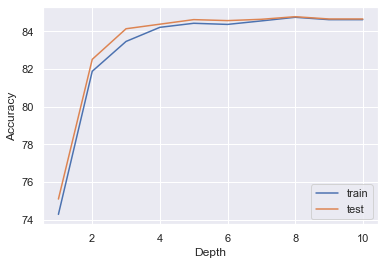

In [57]:
test_accuracy = []
train_accuracy = []
depth = []
for i in range(1,grid.best_params_['max_depth']+1):
    dtc = DecisionTreeClassifier(criterion = 'gini', max_depth=i, max_leaf_nodes=20)
# Train Decision Tree Classifer
    dtc = dtc.fit(x1_train,y1_train)

    predictionstest = dtc.predict(x1_test)
    predictionstrain = dtc.predict(x1_train)

    test_accuracy.append(accuracy_score(y1_test,predictionstest)*100)
    train_accuracy.append(accuracy_score(y1_train,predictionstrain)*100)
    depth.append(i)
    
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.plot(depth,train_accuracy, label='train')
plt.plot(depth,test_accuracy, label='test')
plt.legend()
plt.show()

In [58]:
model = DecisionTreeClassifier(criterion = 'gini', max_depth=10, max_leaf_nodes=20)
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.85200297 0.84044527 0.83302412 0.84489796 0.84526902]
Accuracy: 0.84 (+/- 0.01)


# BOOSTING

In [7]:
%%time
adb = AdaBoostClassifier(n_estimators=1000,learning_rate=1)
adb = adb.fit(x1_train, y1_train)
AdaBoostClassifier()

NameError: name 'x1_train' is not defined

In [123]:
#Predict the response for test dataset
predictions = adb.predict(x1_test)
# print classification report 
print('Accuracy:',accuracy_score(y1_test,predictions))
print('Confusion Matrix: \n',confusion_matrix(y1_test, predictions))
print('Classification Report: \n',classification_report(y1_test, predictions)) 

Accuracy: 0.8601108033240997
Confusion Matrix: 
 [[3988  270]
 [ 538  980]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      4258
           1       0.78      0.65      0.71      1518

    accuracy                           0.86      5776
   macro avg       0.83      0.79      0.81      5776
weighted avg       0.86      0.86      0.86      5776



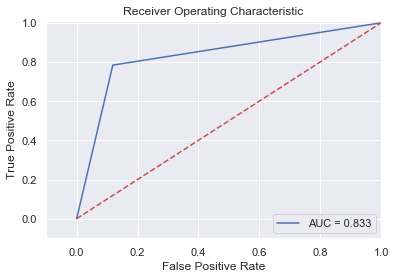

In [124]:
roc_auc(predictions,y1_test)

In [61]:
param_grid = {"n_estimators": [50, 100, 500, 1000, 2000],
              "learning_rate": [0.1, 1, 2]
              }
grid = GridSearchCV(AdaBoostClassifier(), param_grid, refit = True, verbose = 2) 

grid.fit(x1_train, y1_train)

print('Best Parameter: ', grid.best_params_) 

print('Model: ', grid.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.5s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ............... learning_rate=0.1, n_estimators=50, total=   0.5s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   1.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   1.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .............. learning_rate=0.1, n_estimators=100, total=   1.0s
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] .

[CV] ................ learning_rate=2, n_estimators=100, total=   1.0s
[CV] learning_rate=2, n_estimators=500 ...............................
[CV] ................ learning_rate=2, n_estimators=500, total=   4.8s
[CV] learning_rate=2, n_estimators=500 ...............................
[CV] ................ learning_rate=2, n_estimators=500, total=   4.7s
[CV] learning_rate=2, n_estimators=500 ...............................
[CV] ................ learning_rate=2, n_estimators=500, total=   4.7s
[CV] learning_rate=2, n_estimators=500 ...............................
[CV] ................ learning_rate=2, n_estimators=500, total=   4.8s
[CV] learning_rate=2, n_estimators=500 ...............................
[CV] ................ learning_rate=2, n_estimators=500, total=   4.8s
[CV] learning_rate=2, n_estimators=1000 ..............................
[CV] ............... learning_rate=2, n_estimators=1000, total=   9.6s
[CV] learning_rate=2, n_estimators=1000 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  8.9min finished


Best Parameter:  {'learning_rate': 1, 'n_estimators': 1000}
Model:  AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=1000, random_state=None)


In [62]:
grid_predictions = grid.predict(x1_test)
print('Accuracy:',accuracy_score(y1_test,grid_predictions))
print('Confusion Matrix: \n', confusion_matrix(y1_test,grid_predictions))
print('Classification Report: \n', classification_report(y1_test,grid_predictions))

Accuracy: 0.8623614958448753
Confusion Matrix: 
 [[4026  311]
 [ 484  955]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      4337
           1       0.75      0.66      0.71      1439

    accuracy                           0.86      5776
   macro avg       0.82      0.80      0.81      5776
weighted avg       0.86      0.86      0.86      5776



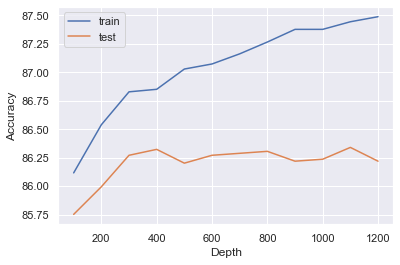

In [63]:
test_accuracy = []
train_accuracy = []
depth = []
for i in range(100,grid.best_params_['n_estimators']+300,100):
    dtc = AdaBoostClassifier(n_estimators=i, learning_rate=1)
# Train Decision Tree Classifer
    dtc = dtc.fit(x1_train,y1_train)

    predictionstest = dtc.predict(x1_test)
    predictionstrain = dtc.predict(x1_train)

    test_accuracy.append(accuracy_score(y1_test,predictionstest)*100)
    train_accuracy.append(accuracy_score(y1_train,predictionstrain)*100)
    depth.append(i)
    
plt.xlabel('No. of Estimators')
plt.ylabel('Accuracy')
plt.plot(depth,train_accuracy, label='train')
plt.plot(depth,test_accuracy, label='test')
plt.legend()
plt.show()

In [64]:
model = AdaBoostClassifier(n_estimators=1000, learning_rate=1)
scores = cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=5)
print('Scores: ',scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores:  [0.87203264 0.86419295 0.8567718  0.86085343 0.86382189]
Accuracy: 0.86 (+/- 0.01)


In [3]:
b= np.zeros(1, dtype=np.float64)

In [2]:
import numpy as np

In [4]:
b

array([0.])